# OMMX AdapterでQUBOからサンプリングする

ここでは巡回セールスマン問題を例として、問題をQUBOに変換しサンプリングを行う方法を説明します。

巡回セールスマン問題（TSP）は一人のセールスマンが複数の都市を順番に巡る方法を求める問題です。都市間の移動コストが与えられたとき、最短の経路を求める問題です。ここでは次の都市の配置を考えましょう

In [1]:
# From ulysses16.tsp in TSPLIB
ulysses16_points = [
    (38.24, 20.42),
    (39.57, 26.15),
    (40.56, 25.32),
    (36.26, 23.12),
    (33.48, 10.54),
    (37.56, 12.19),
    (38.42, 13.11),
    (37.52, 20.44),
    (41.23, 9.10),
    (41.17, 13.05),
    (36.08, -5.21),
    (38.47, 15.13),
    (38.15, 15.35),
    (37.51, 15.17),
    (35.49, 14.32),
    (39.36, 19.56),
]

都市の位置をプロットしてみましょう

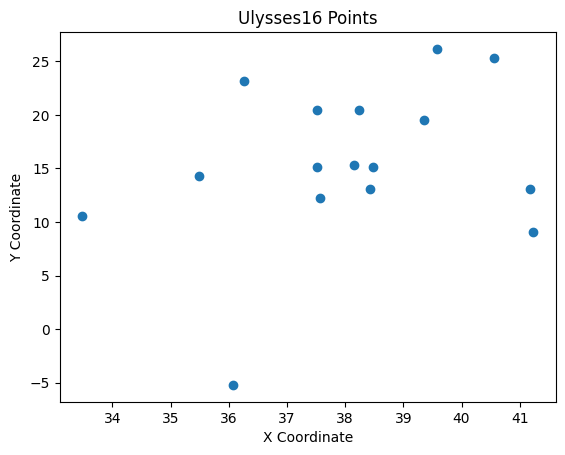

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

x_coords, y_coords = zip(*ulysses16_points)
plt.scatter(x_coords, y_coords)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Ulysses16 Points')
plt.show()

$i$番目の都市と$j$番目の都市の距離 $d(i, j)$を計算しておきます。

In [3]:
def distance(x, y):
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2)**0.5

# 都市の数
N = len(ulysses16_points)
# 各都市間の距離
d = [[distance(ulysses16_points[i], ulysses16_points[j]) for i in range(N)] for j in range(N)]

これを使って次のような最適化問題としてTSPを定式化します。まずある時刻 $t$ に都市 $i$ にいるかどうかをバイナリ変数 $x_{t, i}$ で表します。このとき、以下の制約を満たすような $x_{t, i}$ を求めます。するとセールスマンが移動する距離は次で与えられます：

$$
\sum_{t=0}^{N-2} \sum_{i, j = 0}^{N-1} d(i, j) x_{t, i} x_{t+1, j}
$$

ただし $x_{t, i}$ は自由に取れるわけではなく、各時刻 $t$ において一箇所の都市にしかいられないという制約と各都市について一度だけ訪れるという制約

$$
\sum_{i=0}^{N-1} x_{t, i} = 1, \quad \sum_{t=0}^{N-1} x_{t, i} = 1
$$

を満たす必要があります。これらを合わせてTSPは制約付き最適化問題として定式化できます

$$
\begin{align*}
\min \quad & \sum_{t=0}^{N-2} \sum_{i, j = 0}^{N-1} d(i, j) x_{t, i} x_{t+1, j} \\
\text{s.t.} \quad & \sum_{i=0}^{N-1} x_{t, i} = 1 \quad (\forall t = 0, \ldots, N-1) \\
\quad & \sum_{t=0}^{N-1} x_{t, i} = 1 \quad (\forall i = 0, \ldots, N-1)
\end{align*}
$$

これに対応する `ommx.v1.Instance` は次のように作成できます

In [4]:
from ommx.v1 import DecisionVariable, Instance

x = [[
        DecisionVariable.binary(
            i + N * t,  # 決定変数のID
            name="x",           # 決定変数の名前、解を取り出すときに使う
            subscripts=[t, i])  # 決定変数の添字、解を取り出すときに使う
        for i in range(N)
    ]
    for t in range(N)
]

objective = sum(
    d[i][j] * x[t][i] * x[t+1][j]
    for i in range(N)
    for j in range(N)
    for t in range(N-1)
)
place_constraint = [
    (sum(x[t][i] for i in range(N)) == 1)
        .set_id(t)  # type: ignore
        .add_name("place")
        .add_subscripts([t])
    for t in range(N)
]
time_constraint = [
    (sum(x[t][i] for t in range(N)) == 1)
        .set_id(i + N)  # type: ignore
        .add_name("time")
        .add_subscripts([i])
    for i in range(N)
]

instance = Instance.from_components(
    decision_variables=[x[t][i] for i in range(N) for t in range(N)],
    objective=objective,
    constraints=place_constraint + time_constraint,
    sense=Instance.MINIMIZE
)

バイナリの決定変数の作成時 `DecisionVariable.binary` に追加した決定変数の名前と添字は後で得られたサンプルを解釈する際に使います。

## QUBOへの変換

OpenJijはQUBO(Quadratic Unconstrained Binary Optimization)問題を解くためのライブラリです。上で定式化した巡回セールスマン問題は変数は全てバイナリですが、制約条件があるためUnconstrainedではありません。そこでペナルティ法によって制約条件を目的関数に押し込む事で制約なし問題に変換します。OMMXの [`Instance.uniform_penalty_method`](https://jij-inc.github.io/ommx/python/ommx/autoapi/ommx/v1/index.html#ommx.v1.Instance.uniform_penalty_method) は等式制約付き問題

$$
\begin{align*}
\min \quad &f(x) \\
\text{s.t.} \quad &g_i(x) = 0 \quad (\forall i)
\end{align*}
$$

を一つのパラメータ $\lambda$ を持つ制約なし問題

$$
\min \quad f(x) + \lambda \sum_i g_i(x)^2
$$

に変換します。また重みパラメータを制約毎に指定したい場合は [`Instance.penalty_method`](https://jij-inc.github.io/ommx/python/ommx/autoapi/ommx/v1/index.html#ommx.v1.Instance.penalty_method) を使うと

$$
\min \quad f(x) + \sum_i \lambda_i g_i(x)^2
$$

という形に変換できます。

In [5]:
parametric_qubo = instance.uniform_penalty_method()

これは決定変数でないパラメータをもっているため `ommx.v1.Instance` ではなくて `ommx.v1.ParametricInstance` という型になっていて、次のパラメータ付きQUBOに対応します。

$$
\min \quad \sum_{t=0}^{N-2} \sum_{i, j = 0}^{N-1} d(i, j) x_{t, i} x_{t+1, j}
+ \lambda \left[ \sum_{t=0}^{N-1} \left(\sum_{i=0}^{N-1} x_{t, i} - 1\right)^2
+ \sum_{i=0}^{N-1} \left(\sum_{t=0}^{N-1} x_{t, i} - 1\right)^2 \right]
$$

この `ParametricInstance` がどのようなパラメータを持っているかは `parameters` プロパティで確認できます。

In [6]:
parametric_qubo.parameters

,name,subscripts,description
id,,,
256,uniform_penalty_weight,[],<NA>


上で説明したように `uniform_penalty_method` は単一のペナルティ重みをパラメータとして持つので一つだけパラメータが存在します。これを $\lambda = 1.0$ に固定するには次のように `with_parameters` でパラメータを指定します。この関数はパラメータのIDに対して値を指定する辞書 `dict[int, float]` を引数に取ります。

In [7]:
weight = parametric_qubo.get_parameters()[0]
qubo = parametric_qubo.with_parameters({weight.id: 1000.0})

ここで得られた `qubo` は全てのパラメータが代入されたので `ommx.v1.ParametricInstance` ではなくて `ommx.v1.Instance` になっており、また制約条件を一つも持たない制約なし最適化問題になっています。

In [8]:
assert qubo.get_constraints() == []

## OpenJijによるサンプリング

`ommx.v1.Instance` で記述されたQUBOをOpenJijを使ってサンプリングするには `ommx-openjij-adapter` を使います。

In [9]:
import ommx_openjij_adapter as adapter

samples = adapter.sample_qubo_sa(qubo, num_reads=9)
sample_set = qubo.evaluate_samples(samples)
sample_set.summary

,objective,feasible
sample_id,,
1,103.687965,True
8,128.650172,True
7,129.517102,True
0,129.805812,True
6,134.162299,True
3,134.957566,True
5,135.814297,True
2,139.594691,True
4,140.764395,True


`ommx_openjij_adapter.sample_qubo_sa` は `ommx.v1.Samples` を返し、これを `Instance.evaluate_samples` に渡すことで目的関数の値や制約条件の破れを計算できます。`SampleSet.summary` プロパティはこれらの要約情報を表示するためのものです。各制約条件毎のfeasibilityを見るには `summary_with_constraints` プロパティを使います。

In [10]:
sample_set.summary_with_constraints

,objective,feasible,place[0],place[1],place[2],place[3],place[4],place[5],place[6],place[7],...,time[6],time[7],time[8],time[9],time[10],time[11],time[12],time[13],time[14],time[15]
sample_id,,,,,,,,,,,,,,,,,,,,,
1,103.687965,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
8,128.650172,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
7,129.517102,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
0,129.805812,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6,134.162299,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,134.957566,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
5,135.814297,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,139.594691,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,140.764395,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


より詳しい情報は `SampleSet.decision_variables` 及び `SampleSet.constraints` プロパティを使って取得できます。得られたサンプルを取得するには `SampleSet.extract_decision_variables` メソッドを使います。これは `ommx.v1.DecisionVariables` を作る時に登録した `name` と `subscripts` を使ってサンプルを解釈します。例えばサンプルID 0 の `x` という名前の決定変数の値を取得するには次のようにすると `dict[subscripts, value]` の形で取得できます。

In [11]:
x = sample_set.extract_decision_variables("x", 0)
x[(0, 0)]

0.0

$x_{t, i}$に対するサンプルが得れたのでこれをTSPのパスに変換します。これは今回の定式化自体に依存するので自分で処理を書く必要があります。決定変数のサンプルは `extract_decision_variables` を使うと決定変数の作成時に登録した `subscripts` を使って `dict[subscripts, value]` の形で取得できます。

In [12]:
def sample_to_path(sample: dict[tuple[int, ...], float]) -> list[int]:
    path = []
    for t in range(N):
        for i in range(N):
            if sample[(t, i)] == 1:
                path.append(i)
    return path

これを表示してみましょう。

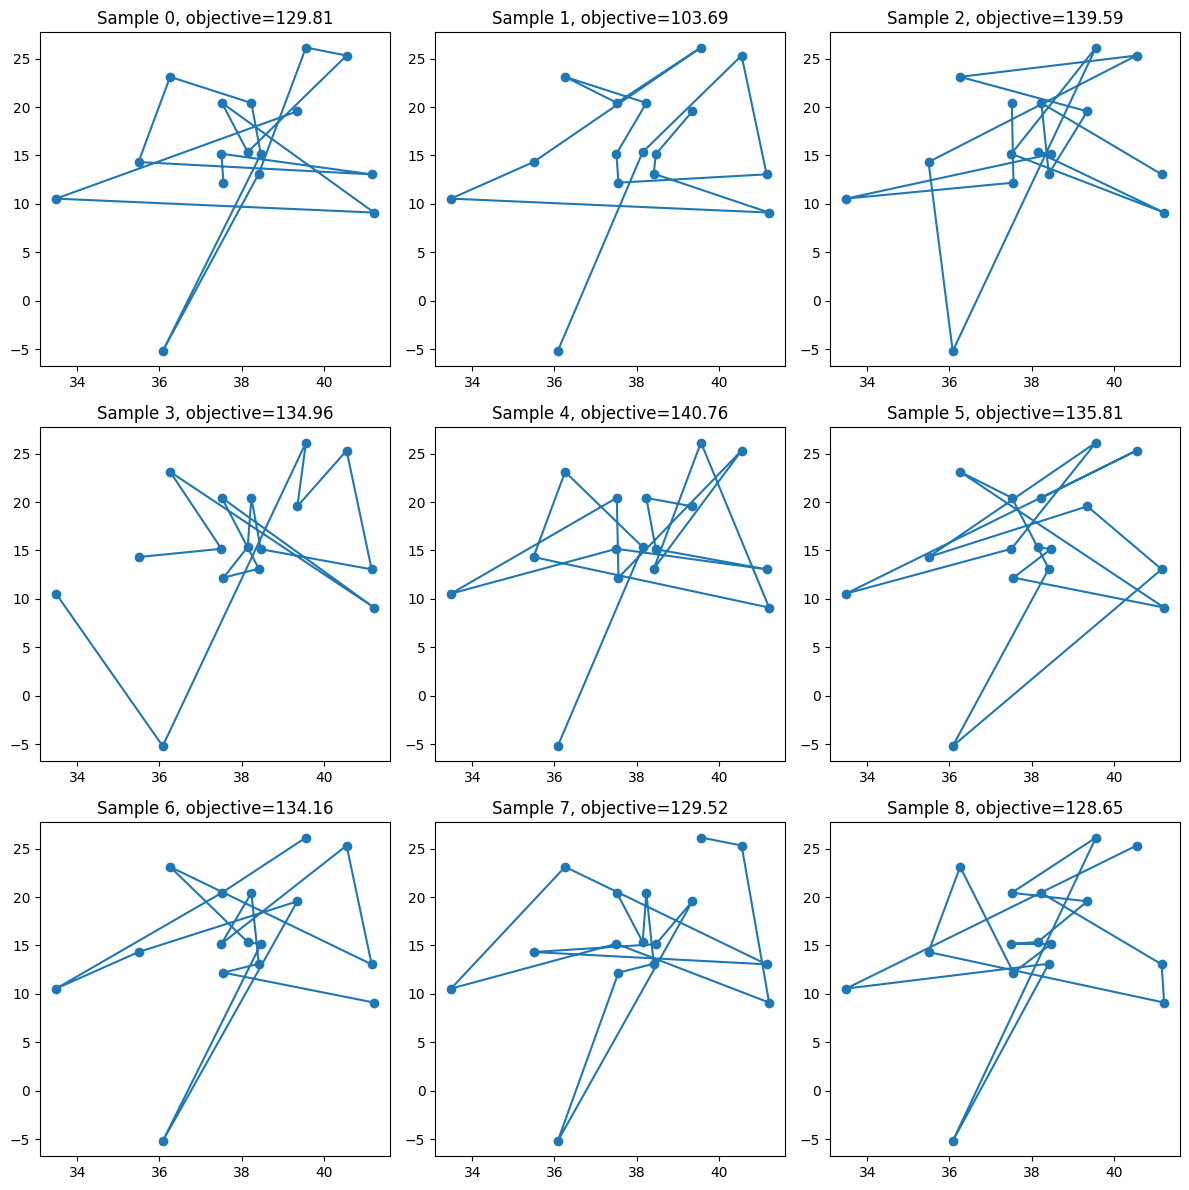

In [13]:
fig, axie = plt.subplots(3, 3, figsize=(12, 12))

for s, ax in enumerate(axie.flatten()):
    x = sample_set.extract_decision_variables("x", s)
    path = sample_to_path(x)
    ax.plot([ulysses16_points[i][0] for i in path], [ulysses16_points[i][1] for i in path], marker='o')
    ax.set_title(f"Sample {s}, objective={sample_set.objectives[s]:.2f}")

plt.tight_layout()
plt.show()